In [34]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

Running Problem 1 with step scheme ...
Running solver with S_8 quadrature ...

Running Problem 2 with diamond difference scheme ...
Running solver with S_2 quadrature ...
Running solver with S_8 quadrature ...

Running Problem 3 with step scheme ...
Running solver with S_8 quadrature ...
Iteration 100: maximum relative error = 6.427377e-03
Iteration 200: maximum relative error = 3.984956e-03
Iteration 300: maximum relative error = 2.557332e-03
Iteration 400: maximum relative error = 1.484775e-03
Iteration 500: maximum relative error = 7.915433e-04
Iteration 600: maximum relative error = 4.001536e-04
Iteration 700: maximum relative error = 1.965215e-04
Iteration 800: maximum relative error = 9.510149e-05
Iteration 900: maximum relative error = 4.568864e-05
Iteration 1000: maximum relative error = 2.187255e-05

Running Problem 4 with diamond difference scheme ...
Running solver with S_8 quadrature ...
Iteration 100: maximum relative error = 6.769969e-03
Iteration 200: maximum relative er

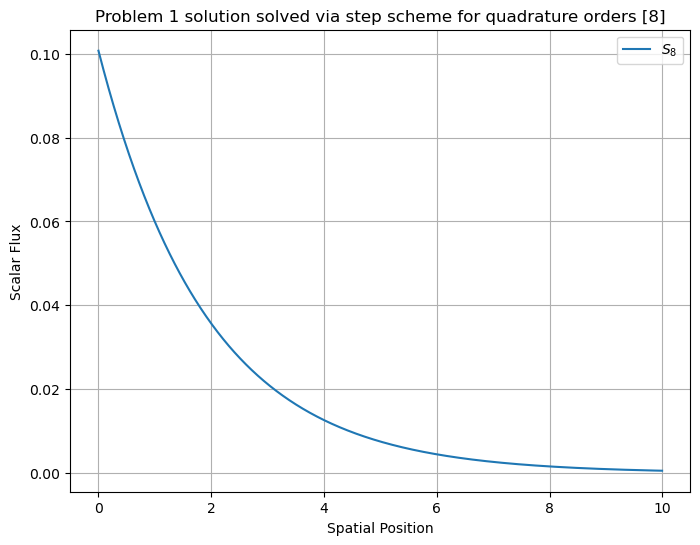

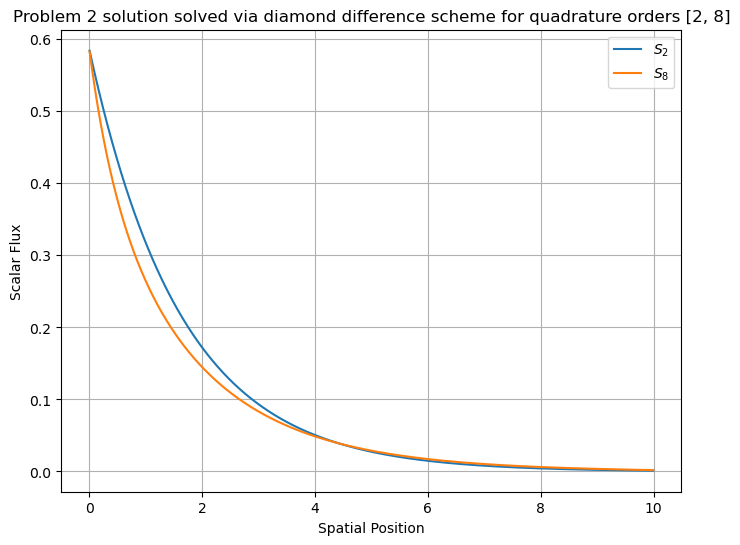

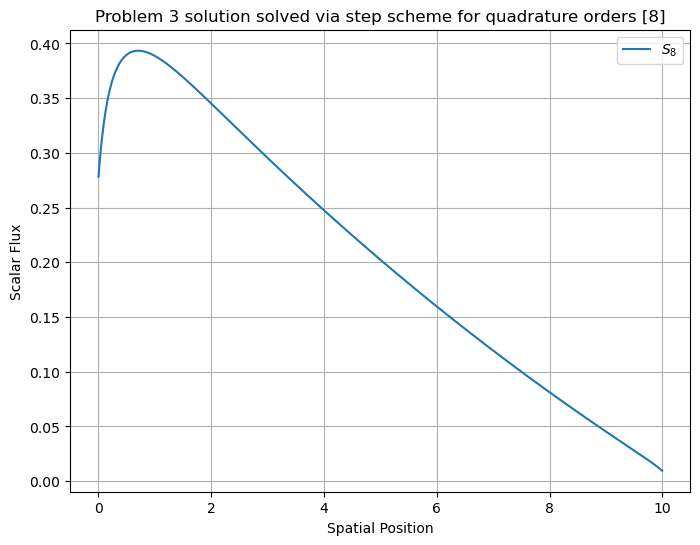

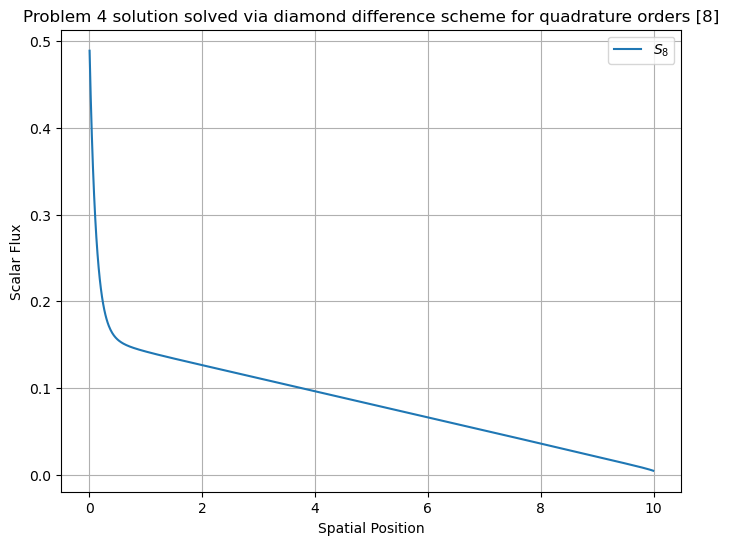

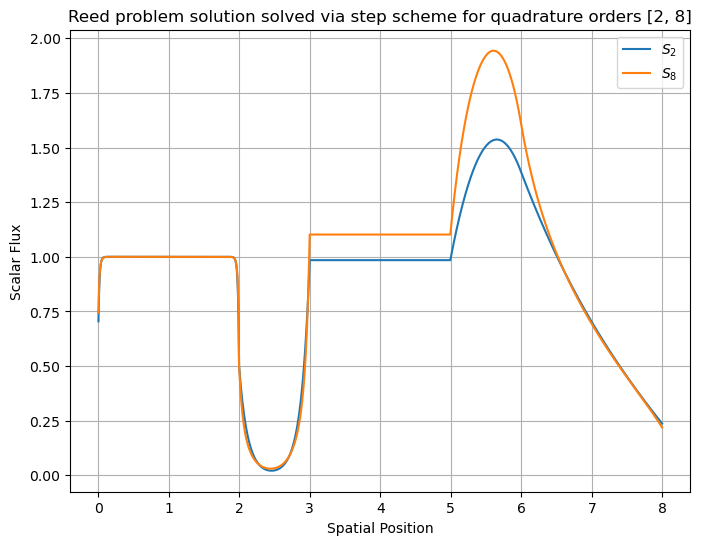

In [ ]:
# Quadrature class to compute discrete ordinates (S_N) quadrature
class Quadrature:
    def __init__(self, quad_order):
        assert quad_order % 2 == 0, "Quadrature order must be even"
        # Compute Gauss-Legendre quadrature rules
        self.mus, self.weights = scipy.special.roots_legendre(quad_order)

    def get_quadrature(self):
        return self.mus, self.weights

# Mesh class for 1D spatial mesh representation
class Mesh:
    def __init__(self, max_mesh_width, num_points):
        self.mesh, self.dx = np.linspace(0, max_mesh_width, num_points, 
                                         retstep=True)
        self.num_cells = num_points - 1

    def get_mesh(self):
        return self.mesh, self.dx, self.num_cells

# Material properties class to assign material properties to mesh cells
class MaterialProperties:
    def __init__(self, sigma_t_zones, sigma_s_zones, q_zones, mesh, num_cells):
        self.sigma_t = np.zeros(num_cells)
        self.sigma_s = np.zeros(num_cells)
        self.ext_src = np.zeros(num_cells)

        # Compute midpoints of cells
        midpoints = 0.5 * (mesh[:-1] + mesh[1:])

        # Assign material properties efficiently using NumPy boolean masks
        # Identify cells in this zone
        for zone, sigma_t in sigma_t_zones.items():
            mask = (zone[0] <= midpoints) & (midpoints <= zone[1])
            self.sigma_t[mask] = sigma_t
            self.sigma_s[mask] = sigma_s_zones[zone]
            self.ext_src[mask] = q_zones[zone]

    def return_xs_and_ext_source(self):
        return self.sigma_t, self.sigma_s, self.ext_src

# Solver class to perform source iteration
class Solver:
    def __init__(self, problem_name, psi_left, psi_right, sigma_t_zones, 
                 sigma_s_zones, q_zones, mesh_width, num_mesh_points, 
                 quad_orders, solver_type="diamond difference",
                max_iters=1000, rel_err_eps=1e-5):
        self.problem_name = problem_name
        self.psi_left = psi_left 
        self.psi_right = psi_right
        self.solver_type = solver_type
        self.rel_err_eps, self.max_iters = rel_err_eps, max_iters
        
        # Initialize mesh and material properties
        self.mesh_obj = Mesh(mesh_width, num_mesh_points)
        self.mesh, self.mesh_dx, self.num_cells = self.mesh_obj.get_mesh()

        # Extract mesh material properties
        self.material_properties = MaterialProperties(sigma_t_zones, 
                                                      sigma_s_zones, q_zones, 
                                                      self.mesh, self.num_cells)
        self.sigma_t, self.sigma_s, self.ext_src = self.material_properties.return_xs_and_ext_source()
        
        # Quadrature orders to loop over
        self.quad_orders = quad_orders
        
    def plot_scalar_fluxes(self, results):
        plt.figure(figsize=(8, 6))
        mesh_centers = 0.5 * (self.mesh[:-1] + self.mesh[1:])
        
        for quad_order, fluxes in results.items():
            plt.plot(mesh_centers, fluxes, label=rf"$S_{{{quad_order}}}$", 
                     linestyle='-')
        plt.xlabel("Spatial Position")
        plt.ylabel("Scalar Flux")
        plt.legend()
        plt.title(f"{self.problem_name} solution solved via {self.solver_type} scheme for # of directions = {self.quad_orders}")
        plt.grid()
        plt.show()

    def run(self):
        results = {} # Store scalar flux results for each quadrature order
        
        print(f"Running {self.problem_name} with {self.solver_type} scheme ...")
        
        for quad_order in self.quad_orders:
            print(f"Running solver with S_{quad_order} quadrature ...")
            
            # Initialize quadrature
            quadrature = Quadrature(quad_order)
            mus, weights = quadrature.get_quadrature()
            
            # Warn if diamond-difference stability condition is not met
            is_dd_positivity_condition_met = (np.min(self.sigma_t) *
                                              self.mesh_dx)/(np.min(np.abs(mus))) > 1.0
            if (self.solver_type == "diamond difference") and (not is_dd_positivity_condition_met):
                print("Warning: Diamond-difference stability condition is not met; solution not guaranteed to be positive")
            
            # Initialize scalar fluxes
            curr_scalar_fluxes = np.full(self.num_cells, np.log(2))
            new_scalar_fluxes  = np.zeros(self.num_cells)
            
            # Perform source iteration until scalar flux relative error (in all mesh cells)
            # between previous and current scalar flux iterates is below eps
            iter_count = 0
            while True:
                iter_count += 1
                
                # Initial guess for source term
                curr_source_term = 0.5 * (self.ext_src + self.sigma_s * curr_scalar_fluxes) 

                # Loop over angles
                for mu_d, mu in enumerate(mus):
                    forward_sweep = mu < 0.0 # Determine the traversal order
                    idx_range = np.arange(0, self.num_cells, 1) if forward_sweep else np.arange(self.num_cells-1, -1, -1) # Determine the starting and ending cell indices
                    psi_d_in = self.psi_left[mu_d] if forward_sweep else self.psi_right[mu_d] # Extract incident flux, depending on traversal order
                    dx_div_abs_mu = self.mesh_dx / np.abs(mu) # Auxiliary term

                    # psi_d_out = (curr_source_term[i]*dx_div_abs_mu + (psi_d_in - (1-pf1) * sigma_t_mult_dx_abs_mu*psi_d_in) / \
                    #                 (1 + pf2*sigma_t_mult_dx_abs_mu)
                    # Step scheme: (pf1, pf2) = 1.0, 1.0
                    # Diamond-difference scheme: (pf1, pf2) = 0.5, 0.5
                    
                    # psi_{d, i} = pf3*psi_{d, i+1/2} + pf4*psi_{d, i-1/2}
                    # Step scheme: (pf3, pf4) = (1.0, 0.0) if sweeping forward else (0.0, 1.0)
                    # Diamond-difference scheme: (pf3, pf4) = (0.5, 0.5)
                    
                    pf1, pf2, pf3, pf4 = None, None, None, None
                    if self.solver_type == 'diamond difference':
                        pf1, pf2, pf3, pf4 = 0.5, 0.5, 0.5, 0.5
                    elif self.solver_type == 'step': # Step scheme
                        pf1, pf2 = 1.0, 1.0
                        pf3, pf4 = (1.0, 0.0) if forward_sweep else (0.0, 1.0)
                    else:
                        raise ValueError("Unknown solver type")

                    # Loop over cells
                    for i in idx_range:
                        sigma_t_mult_dx_abs_mu = self.sigma_t[i] * dx_div_abs_mu
                        psi_d_out = (curr_source_term[i]*dx_div_abs_mu + (1 - (1-pf1) * sigma_t_mult_dx_abs_mu)*psi_d_in) / (1 + pf2*sigma_t_mult_dx_abs_mu)
                        psi_d =  pf3*psi_d_out + pf4*psi_d_in
                        new_scalar_fluxes[i] += psi_d * weights[mu_d] # Update scalar flux, direction by direction
                        psi_d_in = psi_d_out # Update incident flux for next cell
                        
                max_scalar_flux_rel_err = np.max(np.abs((new_scalar_fluxes - curr_scalar_fluxes) / curr_scalar_fluxes)) # Compute relative error
                curr_scalar_fluxes, new_scalar_fluxes[:] = np.copy(new_scalar_fluxes), 0.0 # Reset scalar flux iterates

                if (iter_count % 100 == 0):
                    print(f"Iteration {iter_count}: maximum relative error = {max_scalar_flux_rel_err:.6e}")
                    
                if (max_scalar_flux_rel_err <= self.rel_err_eps):
                    break
                if (iter_count > self.max_iters):
                    print("Warning: Iteration limit reached without convergence!")
                    break
            
            results[quad_order] = curr_scalar_fluxes # Store scalar flux for current quadrature order
            
        self.plot_scalar_fluxes(results) # Plot the scalar fluxes for all quadrature orders
        print()

if __name__ == '__main__':
    problems = [
        # Homogenous slab, L=10, pure absorber with sigma_t = 0.5, unit incident flux on the left extremity 
        # is along the most normal direction in the S8 quadrature. 
        {"problem_name": "Problem 1", "mesh_width": 10.0, "num_mesh_points": 1000, "quad_orders": [8], 
         "psi_left": np.array([1.0] + [0.0] * 7), "psi_right": np.zeros(8),
         "sigma_t_zones": {(0.0, 10.0): 0.5}, "sigma_s_zones": {(0.0, 10.0): 0.0}, 
         "q_zones": {(0.0, 10.0): 0.0}, "solver_type": "step", "max_iters": 1000,
         "rel_err_eps": 1e-5},
        
        # Homogenous slab, L=10, sigma_t = 0.5, sigma_s = 0.25, isotropic incident to the left
        # Use S2 and S8 quadratures
        {"problem_name": "Problem 2", "mesh_width": 10.0, "num_mesh_points": 1000, "quad_orders": [2, 8], 
         "psi_left": 0.5 * np.ones(8), "psi_right": np.zeros(8),
         "sigma_t_zones": {(0.0, 10.0): 0.5}, "sigma_s_zones": {(0.0, 10.0): 0.25}, 
         "q_zones": {(0.0, 10.0): 0.0}, "solver_type": "diamond difference", "max_iters": 1000,
         "rel_err_eps": 1e-5},
        
        # Homogenous slab, L=10, sigma_t = 0, sigma_s = 2, unit incident flux on the left extremity is along 
        # the most normal direction in the S8 quadrature.
        {"problem_name": "Problem 3", "mesh_width": 10.0, "num_mesh_points": 1000, "quad_orders": [8], 
         "psi_left": np.array([1.0] + [0.0] * 7), "psi_right": np.zeros(8),
         "sigma_t_zones": {(0.0, 10.0): 2.0}, "sigma_s_zones": {(0.0, 10.0): 2.0}, 
         "q_zones": {(0.0, 10.0): 0.0}, "solver_type": "step", "max_iters": 1000,
         "rel_err_eps": 1e-5},
        
        # Homogenous slab, L=10, sigma_t = 0, sigma_s = 2, unit incident flux on the left extremity is along 
        # the most grazing direction in the S8 quadrature
        {"problem_name": "Problem 4", "mesh_width": 10.0, "num_mesh_points": 1000, "quad_orders": [8], 
         "psi_left": np.array([0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]), "psi_right": np.zeros(8),
         "sigma_t_zones": {(0.0, 10.0): 2.0}, "sigma_s_zones": {(0.0, 10.0): 2.0}, 
         "q_zones": {(0.0, 10.0): 0.0}, "solver_type": "diamond difference", "max_iters": 1000,
         "rel_err_eps": 1e-5},
        
        # Reed problem
        {"problem_name": "Reed problem", "mesh_width": 8.0, "num_mesh_points": 1000, "quad_orders": [2, 8], 
         "psi_left": np.zeros(8), "psi_right": np.zeros(8),
         "sigma_t_zones": {(0.0, 2.0): 50.0, (2.0, 3.0): 5.0, (3.0, 5.0): 0.0, (5.0, 6.0): 1.0, (6.0, 8.0): 1.0},
         "sigma_s_zones": {(0.0, 2.0): 0.0, (2.0, 3.0): 0.0, (3.0, 5.0): 0.0, (5.0, 6.0): 0.9, (6.0, 8.0): 0.9},
         "q_zones": {(0.0, 2.0): 50.0, (2.0, 3.0): 0.0, (3.0, 5.0): 0.0, (5.0, 6.0): 1.0, (6.0, 8.0): 0.0},
         "solver_type": "step", "max_iters": 1000,
         "rel_err_eps": 1e-5}
    ]

    for prob in problems:
        solver = Solver(
            problem_name=prob["problem_name"],
            psi_left=prob["psi_left"], psi_right=prob["psi_right"], 
            sigma_t_zones=prob["sigma_t_zones"], sigma_s_zones=prob["sigma_s_zones"], 
            q_zones=prob["q_zones"], mesh_width=prob["mesh_width"], 
            num_mesh_points=prob["num_mesh_points"], quad_orders=prob["quad_orders"], 
            solver_type=prob["solver_type"], max_iters=prob["max_iters"],
            rel_err_eps=prob["rel_err_eps"]
        )
        solver.run()